# 1) Object Detection for Video Game Frames

1.1) Installation of all packages that are required to use detectron2.
- YAML is a data serialization format designed for human readability and interaction with scripting languages.
- code source for detectron2 installation: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
- code source provides another, quicker way of installing detectron2 although it is lacking some packages. Dont install both!
- installing torch is not recommended as Google Colab also has it installed. Dont install again.

In [ ]:
!python -m pip install pyyaml==5.1 
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
#!python -m pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5vzpizoo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5vzpizoo
  Resolved https://github.com/facebookresearch/detectron2.git to commit 58e472e076a5d861fdcf773d9254a3664e045bf8
  Preparing metadata (setup.py) ... done


1.2) Check if all packages are installed with the correct version and import packages needed for object detection.

In [192]:
import torch, detectron2

!nvcc --version #NVIDIA Cuda compiler information
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, cv2, random, re
from google.colab.patches import cv2_imshow
from google.colab import drive

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [130]:
# Constants
numImages = 20 #number of images used for detection
threshold = 0.3 #default is 0.5
createImages = True #creates images with predicted classes shown as bounding box around objects; set to True if you want to create them
gameName = "The_Settlers"
inputPath = f"/content/drive/MyDrive/digital_humanities/Walkthroughts/Siedler_Frames/"
outputPathImages = f"/content/drive/MyDrive/digital_humanities/Ergebnisse/Object_Detection/The_Settlers/"
outputPathCSV = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Object_Detection/"

1.3) Allow Google Colab to access Google Drive Folders so that data can be exchanged.
- mounts your Google Drive (MyDrive) into Files://content/drive/

In [99]:
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.4) Check if a GPU is available for Object Detection; Detectron wont function without a GPU (or it would be very slow)

In [137]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


1.5) Config Detectron2
- setting cfg.MODEL.ROI_HEADS.SCORE_TRESH_TEST threshold for object detection

In [101]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

[01/21 13:50:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


1.6) Reading, writing and displaying images from Google Drive; checking image dimensions so that we can reduce input size

In [121]:
class Images():
  
  fileNames = []
  inputPath = ""
  outputPath = ""

  def __init__(self, inputPath, outputPath):
     self.inputPath = inputPath
     self.outputPath = outputPath

  def readFileNames(self):
    for file in os.listdir(self.inputPath):
      if file.split(".")[-1].lower() in {"jpeg", "jpg"}:
        self.fileNames.append(file)
    
    # code reference: https://stackoverflow.com/a/33159707
    # sort files according to trailing numbering
    self.fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))
    print(f"{len(self.fileNames)} file names were read from {self.inputPath}.")

  def writeFile(self, fileName, imageData):
    cv2.imwrite(self.outputPath + fileName, imageData)

  def getNextImage(self, index):
    fileName = self.fileNames[index]
    return { "data": cv2.imread(self.inputPath + fileName), "name": fileName }
  
  def showExampleImage(self):
    image = self.getNextImage(2)
    cv2_imshow(image["data"])

    print(f"image name: {image['name']}")
    print(f"image shape: {image['data'].shape}")
    print(f"image size (in pixels): {image['data'].size}")
    print(f"image data type: {image['data'].dtype}")

15306 file names were read from /content/drive/MyDrive/digital_humanities/Walkthroughts/Siedler_Frames/.


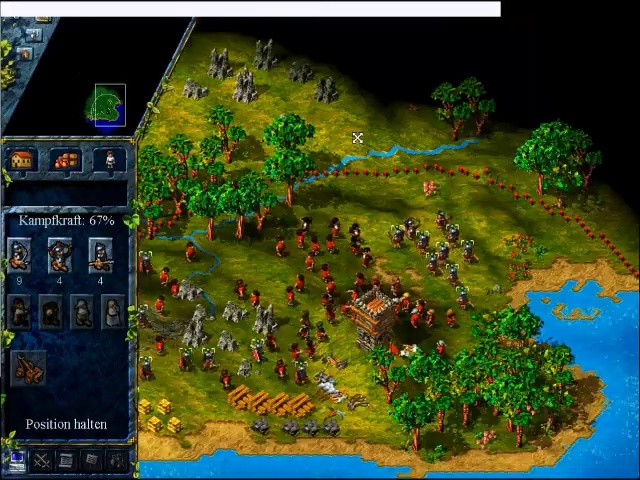

image name: siedler_frame_60.jpg
image shape: (480, 640, 3)
image size (in pixels): 921600
image data type: uint8


In [122]:
images = Images(inputPath, outputPathImages)
images.readFileNames()

images.showExampleImage()

1.7) Test Object Detection on one frame

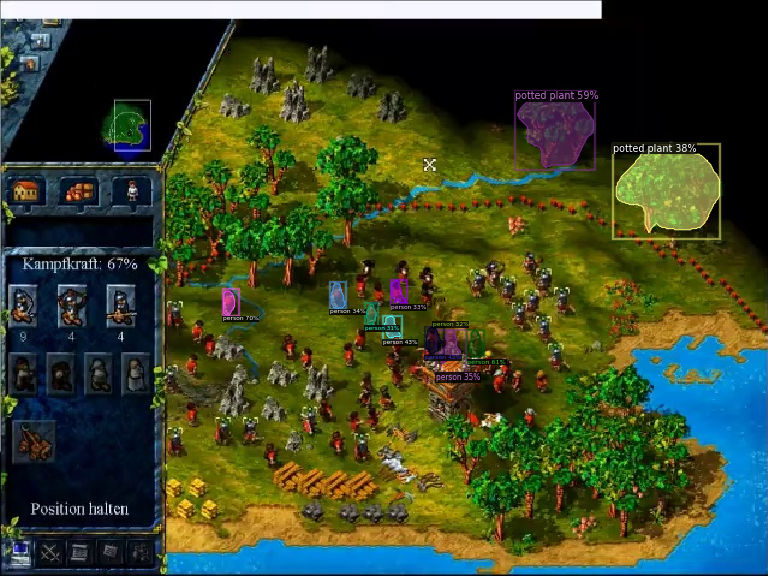

In [127]:
image = images.getNextImage(2)

outputs = predictor(image['data'])

v = Visualizer(image['data'][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:,:,::-1])

1.8) MS COCO dataset class names and function that counts recognised classes

In [105]:
classDict = {0: u'__background__',
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'}

def createBaseDict():
  baseDict = {v: k for k,v in classDict.items()}
  del baseDict["__background__"]
  for item in baseDict:
    baseDict[item] = 0
  return baseDict

def getObjectsPerFrame(classes):
  frameDict = createBaseDict()
  for item in classes:
    classNumber = item.item() + 1
    className = classDict[classNumber]

    frameDict[className] = frameDict[className] + 1

  return frameDict

1.9) read number of images and save predicted classes to dictionary which we convert to pandas frame before saving as csv

In [134]:
allDic = []

counter = 0

while counter < numImages:
  image = images.getNextImage(counter)

  outputs = predictor(image['data'])
  instances = outputs["instances"].pred_classes
  frame = getObjectsPerFrame(instances)
  frame["_id"] = image["name"].split(".")[0]

  allDic.append(frame)

  if createImages:
    v = Visualizer(image['data'][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    images.writeFile(image['name'], out.get_image()[:, :, ::-1])

  counter += 1

In [197]:
data = pd.DataFrame.from_dict(allDic)
data = data.reindex(sorted(data.columns), axis=1)

#data = data.sort_values("_id")
data["sum"] = data.loc[:, "airplane":"zebra"].sum(1)
data

,_id,airplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,...,toothbrush,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra,sum
0,siedler_frame_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,siedler_frame_30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
2,siedler_frame_60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
3,siedler_frame_90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,siedler_frame_120,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5,siedler_frame_150,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
6,siedler_frame_180,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,12
7,siedler_frame_210,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,13
8,siedler_frame_240,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,10
9,siedler_frame_270,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


In [136]:
data.to_csv(outputPathCSV + gameName + ".csv", encoding="utf-8")

# 2 Analysis
- read csv with results from google drive

### Agenda:

Done:
- Image(s) with most recognised items
- Image(s) with most different recognised items
- Image(s) with highest number of class "person"
- Total of recognised items per column
- Total of recognised items
- Number of class "person" per frame
- Frames with at least one instance of class "person"
- Class with highest number of recognitions

Todo:
- percentage of images with recognised classes
- print histogram of items
- print graph where class appears
- find rows where items appear
- mean of objects detected per frame

2.1 Image(s) with most recognised items

In [190]:
data.loc[data["sum"] == data["sum"].max()]["_id"]

11    siedler_frame_330
Name: _id, dtype: object

2.2 Image(s) with most different recognised items

In [189]:
data["num_diff_obj"] = data.loc[:, "airplane":"zebra"].applymap(lambda x: x != 0).sum(True)

data.loc[data["num_diff_obj"] == data["num_diff_obj"].max()]["_id"]

8     siedler_frame_240
11    siedler_frame_330
16    siedler_frame_480
Name: _id, dtype: object

2.3 Image(s) with highest number of class "person"

In [191]:
data.loc[data["person"] == data["person"].max()]["_id"]

11    siedler_frame_330
Name: _id, dtype: object

2.4 Total of recognised items per column
- masked columns where values is zero

In [209]:
sum = data.loc[:,"airplane":"zebra"].sum()
sum[sum > 0 ]

bird               4
broccoli           1
bus                2
cake               1
motorcycle         2
parking meter      3
person           155
potted plant      14
traffic light      7
zebra              3
dtype: int64

2.5 Total of recognised items

In [218]:
sum.sum()

192

2.6 Number of class "person" per frame

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11fa6162b0>]],
      dtype=object)

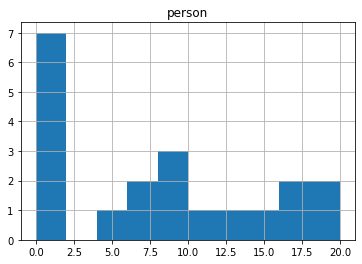

In [220]:
data.hist("person")

2.7 Frames with at least one instance of class "person"

In [219]:
data[data["person"] > 0]["_id"]

1      siedler_frame_30
2      siedler_frame_60
6     siedler_frame_180
7     siedler_frame_210
8     siedler_frame_240
9     siedler_frame_270
10    siedler_frame_300
11    siedler_frame_330
12    siedler_frame_360
13    siedler_frame_390
14    siedler_frame_420
16    siedler_frame_480
17    siedler_frame_510
Name: _id, dtype: object

2.8 Class with highest number of recognitions

In [233]:
sum.idxmax()

'person'